# Modelling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
#import pandas_profiling as pp

# models
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor 
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#import xgboost as xgb
#import lightgbm as lgb

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys

!{sys.executable} -m pip install hyperopt

In [3]:
valid_part = 0.3
pd.set_option('max_columns',100)

In [4]:
train0 = pd.read_csv(r'C:/Users/sukes/Desktop/updatedcleanedvehicles.csv')

train0.head()

,id,url,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,17899,2012.0,volkswagen,golf r,excellent,4,gas,63500.0,clean,manual,4,hatchback,black,ut,40.760779,-111.891047
1,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,46463,2015.0,gmc,sierra 1500,excellent,6,gas,7554.0,clean,automatic,4,truck,white,ut,40.760779,-111.891047
2,7034406932,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,49999,2018.0,ford,f-450,like new,6,diesel,70150.0,clean,automatic,4,pickup,white,ut,40.760779,-111.891047
3,7034406582,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,13999,2009.0,ram,unknown,good,6,gas,120057.0,clean,automatic,4,pickup,silver,ut,40.760779,-111.891047
4,7034405619,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,34500,2017.0,ford,f-350,excellent,6,diesel,95484.0,clean,automatic,4,pickup,white,ut,40.760779,-111.891047


In [5]:
#train0 = pd.read_csv(r'D:/Projects/DPA/Used-Cars-Analysis/data/vehicles_1.csv')

#train0.head()

In [6]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465998 entries, 0 to 465997
Data columns (total 19 columns):
id              465998 non-null int64
url             465998 non-null object
region          465998 non-null object
price           465998 non-null int64
year            465998 non-null float64
manufacturer    465998 non-null object
model           465998 non-null object
condition       465998 non-null object
cylinders       465998 non-null int64
fuel            465998 non-null object
odometer        465998 non-null float64
title_status    465998 non-null object
transmission    465998 non-null object
drive           465998 non-null int64
type            465998 non-null object
paint_color     465998 non-null object
state           465998 non-null object
lat             465998 non-null float64
long            465998 non-null float64
dtypes: float64(4), int64(4), object(11)
memory usage: 67.6+ MB


In [7]:
drop_columns = ['id','url', 'region', 'model', 'title_status', 'state', 'lat','long']
train0 = train0.drop(columns = drop_columns)

In [8]:
null_values=train0.isnull().sum()
null_values=pd.DataFrame(null_values,columns=['null'])
j=1
sum_tot=len(train0)
null_values['percent']=null_values['null']/sum_tot
round(null_values*100,3).sort_values('percent',ascending=False)

,null,percent
price,0,0.0
year,0,0.0
manufacturer,0,0.0
condition,0,0.0
cylinders,0,0.0
fuel,0,0.0
odometer,0,0.0
transmission,0,0.0
drive,0,0.0
type,0,0.0


In [9]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465998 entries, 0 to 465997
Data columns (total 11 columns):
price           465998 non-null int64
year            465998 non-null float64
manufacturer    465998 non-null object
condition       465998 non-null object
cylinders       465998 non-null int64
fuel            465998 non-null object
odometer        465998 non-null float64
transmission    465998 non-null object
drive           465998 non-null int64
type            465998 non-null object
paint_color     465998 non-null object
dtypes: float64(2), int64(3), object(6)
memory usage: 39.1+ MB


In [10]:
# Encoding the categorical features
categorical_columns = train0.select_dtypes(exclude=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

for col in categorical_columns:
    if col in train0.columns:
        le = LabelEncoder()
        train0[[col]] = train0[[col]].apply(le.fit_transform)

In [11]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465998 entries, 0 to 465997
Data columns (total 11 columns):
price           465998 non-null int64
year            465998 non-null float64
manufacturer    465998 non-null int32
condition       465998 non-null int32
cylinders       465998 non-null int64
fuel            465998 non-null int32
odometer        465998 non-null float64
transmission    465998 non-null int32
drive           465998 non-null int64
type            465998 non-null int32
paint_color     465998 non-null int32
dtypes: float64(2), int32(6), int64(3)
memory usage: 28.4 MB


In [12]:
# Thanks to : https://www.kaggle.com/aantonova/some-new-risk-and-clusters-features
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [13]:
train0 = reduce_mem_usage(train0)

Mem. usage decreased to  9.78 Mb (65.6% reduction)


In [14]:
train0.corr()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
price,1.000000,-0.004102,0.003135,-0.002732,-0.000621,0.000329,-0.001053,0.003235,0.000276,-0.000207,-0.000024
year,-0.004102,1.000000,0.004431,-0.002662,-0.144102,0.038335,-0.226688,-0.101696,0.025720,-0.019095,-0.011465
manufacturer,0.003135,0.004431,1.000000,0.006940,-0.184735,-0.056092,0.006768,0.069180,0.012601,0.032957,0.004317
condition,-0.002732,-0.002662,0.006940,1.000000,-0.004740,0.013957,-0.016480,0.012869,0.116344,0.089462,0.098930
cylinders,-0.000621,-0.144102,-0.184735,-0.004740,1.000000,-0.093609,0.064717,-0.025315,0.216314,0.066822,0.033229
fuel,0.000329,0.038335,-0.056092,0.013957,-0.093609,1.000000,-0.089631,0.021274,-0.103656,-0.126553,-0.050877
odometer,-0.001053,-0.226688,0.006768,-0.016480,0.064717,-0.089631,1.000000,-0.023467,0.032304,0.028247,0.017576
transmission,0.003235,-0.101696,0.069180,0.012869,-0.025315,0.021274,-0.023467,1.000000,-0.024569,-0.006183,-0.016783
drive,0.000276,0.025720,0.012601,0.116344,0.216314,-0.103656,0.032304,-0.024569,1.000000,-0.016955,0.089336
type,-0.000207,-0.019095,0.032957,0.089462,0.066822,-0.126553,0.028247,-0.006183,-0.016955,1.000000,0.141106


In [15]:
train0 = train0[train0['price'] > 1000]
train0 = train0[train0['price'] < 40000]
# Rounded ['odometer'] to 5000
train0['odometer'] = train0['odometer'] // 5000
train0 = train0[train0['year'] > 110]

In [16]:
train0.corr()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
price,1.000000,0.393089,-0.002702,0.020415,0.202611,-0.158198,-0.299783,0.036573,0.209137,0.002573,0.002435
year,0.393089,1.000000,0.004814,-0.002636,-0.164182,0.066908,-0.223347,-0.096373,0.008016,-0.023284,-0.013841
manufacturer,-0.002702,0.004814,1.000000,0.006236,-0.189481,-0.059088,0.004572,0.067532,0.008611,0.032962,-0.000391
condition,0.020415,-0.002636,0.006236,1.000000,-0.001328,0.018628,-0.014688,0.019728,0.113429,0.086074,0.098495
cylinders,0.202611,-0.164182,-0.189481,-0.001328,1.000000,-0.085489,0.084753,-0.042226,0.215457,0.072432,0.040093
fuel,-0.158198,0.066908,-0.059088,0.018628,-0.085489,1.000000,-0.110542,0.009946,-0.092934,-0.119570,-0.053050
odometer,-0.299783,-0.223347,0.004572,-0.014688,0.084753,-0.110542,1.000000,-0.029226,0.048776,0.029167,0.019834
transmission,0.036573,-0.096373,0.067532,0.019728,-0.042226,0.009946,-0.029226,1.000000,-0.028208,-0.002807,-0.016298
drive,0.209137,0.008016,0.008611,0.113429,0.215457,-0.092934,0.048776,-0.028208,1.000000,-0.024251,0.086505
type,0.002573,-0.023284,0.032962,0.086074,0.072432,-0.119570,0.029167,-0.002807,-0.024251,1.000000,0.140529


### Preparaing to the Modelling

In [120]:
y = train0['price']
X = train0.drop('price',axis=1)

y = sample['price']
X = sample.drop('price',axis=1)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(340887, 10) (340887,)
(85222, 10) (85222,)


In [122]:
train, test, target, target_test = train_test_split(X, y, test_size=valid_part, random_state=0)

#### Min-max scaler:


#### For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum.

In [123]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()   
X_train= sc.fit_transform(X_train)
X_test= sc.transform(X_test)

C:\Users\sukes\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int8, float16, float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [124]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()   
X_train= sc.fit_transform(train)
X_test= sc.transform(test)

C:\Users\sukes\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int8, float16, float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [125]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []

In [66]:
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

In [67]:
def acc_model(num,model,train,test):
    # Calculation of accuracy of model акщь Sklearn by different metrics   
  
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)
    
    #print('Accuracy for train',model.score(target, ytrain))


    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)
    
    #print('Accuracy for test',model.score(target_test, ytest))


In [126]:
# Linear Regression
linreg = LinearRegression()
linreg.fit(train, target)
acc_model(0,linreg,train,test)

target =  [13918 17500  3850  7900  6499]
ytrain =  [14143.5625 12858.4375 10713.5     8246.875   7355.1875]
acc(r2_score) for train = 33.88
acc(relative error) for train = 41.29
acc(rmse) for train = 676837.51
target_test = [ 2550 14500  9995  3300 11000]
ytest = [ 5876.25  10798.625 12661.625  9160.5   12097.125]
acc(r2_score) for test = 33.4
acc(relative error) for test = 41.23
acc(rmse) for test = 678641.51


In [ ]:
# Support Vector Machines
svr = SVR()
svr.fit(train, target)
acc_model(1,svr,train,test)

In [69]:
# Linear SVR

linear_svr = LinearSVR()
linear_svr.fit(train, target)
acc_model(1,linear_svr,train,test)

target =  [25900  6995 13998 32998 20900]
ytrain =  [22039.15438568 14233.52432095 16170.22938809 21654.14011425
 16329.64495431]
acc(r2_score) for train = -18.66
acc(relative error) for train = 46.91
acc(rmse) for train = 991329.31
target_test = [10997 15750  8995  4990 17940]
ytest = [16241.39845837 16325.2976051   7620.02717559  9428.38187242
 17195.11416565]
acc(r2_score) for test = -25.23
acc(relative error) for test = 46.91
acc(rmse) for test = 1019462.37


In [ ]:

mlp = MLPRegressor()
param_grid = {'hidden_layer_sizes': [i for i in range(2,20)],
              'activation': ['relu'],
              'solver': ['adam'],
              'learning_rate': ['constant'],
              'learning_rate_init': [0.01],
              'power_t': [0.5],
              'alpha': [0.0001],
              'max_iter': [1000],
              'early_stopping': [True],
              'warm_start': [False]}
mlp_GS = GridSearchCV(mlp, param_grid=param_grid, 
                   cv=10, verbose=True, pre_dispatch='2*n_jobs')
mlp_GS.fit(train, target)
acc_model(3,mlp_GS,train,test)

In [71]:
sgd = SGDRegressor()
sgd.fit(train, target)
acc_model(3,sgd,train,test)

target =  [25900  6995 13998 32998 20900]
ytrain =  [3.88674450e+14 3.35245157e+14 3.96019461e+14 4.11452768e+14
 3.54667318e+14]
acc(r2_score) for train = -1.7923075588900295e+23
acc(relative error) for train = 2964585502346.08
acc(rmse) for train = 3.852774956121168e+16
target_test = [10997 15750  8995  4990 17940]
ytest = [4.06185948e+14 3.97234799e+14 3.79723910e+14 3.31813377e+14
 3.93907651e+14]
acc(r2_score) for test = -1.7890815125737667e+23
acc(relative error) for test = 2962081921356.34
acc(rmse) for test = 3.8533247130159624e+16


In [70]:
random_forest = RandomForestRegressor()
random_forest.fit(train, target)
acc_model(2,random_forest,train,test)

target =  [25900  6995 13998 32998 20900]
ytrain =  [23676.19404762  7095.5        14410.525      27396.15
 21211.25332168]
acc(r2_score) for train = 94.38
acc(relative error) for train = 8.96
acc(rmse) for train = 215821.65
target_test = [10997 15750  8995  4990 17940]
ytest = [10672.3        20894.18666667  4024.5        14259.5
 17960.86666667]
acc(r2_score) for test = 83.22
acc(relative error) for test = 17.26
acc(rmse) for test = 373225.9


In [72]:
# Ridge Regressor
ridge = RidgeCV(cv=5)
ridge.fit(train, target)
acc_model(4,ridge,train,test)

target =  [25900  6995 13998 32998 20900]
ytrain =  [18613.57420012 10929.98096088 13784.54649812 18395.55827989
 19452.08767776]
acc(r2_score) for train = 34.77
acc(relative error) for train = 42.0
acc(rmse) for train = 735024.7
target_test = [10997 15750  8995  4990 17940]
ytest = [13042.82289309 14211.64427856  8417.13932353 13225.82138853
 14842.41622516]
acc(r2_score) for test = 34.23
acc(relative error) for test = 42.07
acc(rmse) for test = 738807.5


In [73]:
# Bagging Regressor

bagging = BaggingRegressor()
bagging.fit(train, target)
acc_model(5,bagging,train,test)

target =  [25900  6995 13998 32998 20900]
ytrain =  [24762.91666667  7025.4        14087.         23763.31166667
 21191.65768073]
acc(r2_score) for train = 94.38
acc(relative error) for train = 8.96
acc(rmse) for train = 215755.31
target_test = [10997 15750  8995  4990 17940]
ytest = [10447.3        20227.97333333  3793.5         4011.66666667
 17720.8       ]
acc(r2_score) for test = 83.35
acc(relative error) for test = 17.22
acc(rmse) for test = 371759.35


In [74]:
# Extra Trees Regressor

etr = ExtraTreesRegressor()
etr.fit(train, target)
acc_model(6,etr,train,test)

target =  [25900  6995 13998 32998 20900]
ytrain =  [23427.5         6995.         13998.         25996.5
 21243.83333333]
acc(r2_score) for train = 96.41
acc(relative error) for train = 4.37
acc(rmse) for train = 172462.25
target_test = [10997 15750  8995  4990 17940]
ytest = [10997.         20608.66666667  3729.5         6744.9
 17902.        ]
acc(r2_score) for test = 83.13
acc(relative error) for test = 16.4
acc(rmse) for test = 374186.07


In [75]:
# AdaBoost Regression

Ada_Boost = AdaBoostRegressor()
Ada_Boost.fit(train, target)
acc_model(7,Ada_Boost,train,test)

target =  [25900  6995 13998 32998 20900]
ytrain =  [24116.32310225 10454.44401615 11811.70091302 23300.73582184
 20779.54446295]
acc(r2_score) for train = 49.13
acc(relative error) for train = 42.05
acc(rmse) for train = 649054.08
target_test = [10997 15750  8995  4990 17940]
ytest = [13718.77889775 20284.44768243 10454.44401615 16702.48928605
 20779.54446295]
acc(r2_score) for test = 48.95
acc(relative error) for test = 42.13
acc(rmse) for test = 650931.91


In [76]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Linear SVR', 
              'Random Forest','Stochastic Gradient Decent',
                'RidgeRegressor', 'BaggingRegressor', 'ExtraTreesRegressor', 
              'AdaBoostRegressor', ],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'd_train': acc_train_d,
    'd_test': acc_test_d,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })


In [90]:
models = models[models.Model != 'Stochastic Gradient Decent']

In [91]:
pd.options.display.float_format = '{:,.2f}'.format

In [92]:
print('Prediction accuracy for models by R2 criterion - r2_test')
models.sort_values(by=['r2_test', 'r2_train'], ascending=False)

Prediction accuracy for models by R2 criterion - r2_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
5,BaggingRegressor,94.38,83.35,8.96,17.22,"215,755.31","371,759.35"
2,Random Forest,94.38,83.22,8.96,17.26,"215,821.65","373,225.90"
6,ExtraTreesRegressor,96.41,83.13,4.37,16.40,"172,462.25","374,186.07"
7,AdaBoostRegressor,49.13,48.95,42.05,42.13,"649,054.08","650,931.91"
0,Linear Regression,34.77,34.23,42.00,42.07,"735,025.24","738,808.09"
4,RidgeRegressor,34.77,34.23,42.00,42.07,"735,024.70","738,807.50"
1,Linear SVR,-18.66,-25.23,46.91,46.91,"991,329.31","1,019,462.37"


In [93]:
print('Prediction accuracy for models by relative error - d_test')
models.sort_values(by=['d_test', 'd_train'], ascending=True)

Prediction accuracy for models by relative error - d_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
6,ExtraTreesRegressor,96.41,83.13,4.37,16.40,"172,462.25","374,186.07"
5,BaggingRegressor,94.38,83.35,8.96,17.22,"215,755.31","371,759.35"
2,Random Forest,94.38,83.22,8.96,17.26,"215,821.65","373,225.90"
0,Linear Regression,34.77,34.23,42.00,42.07,"735,025.24","738,808.09"
4,RidgeRegressor,34.77,34.23,42.00,42.07,"735,024.70","738,807.50"
7,AdaBoostRegressor,49.13,48.95,42.05,42.13,"649,054.08","650,931.91"
1,Linear SVR,-18.66,-25.23,46.91,46.91,"991,329.31","1,019,462.37"


In [94]:
print('Prediction accuracy for models by RMSE - rmse_test')
models.sort_values(by=['rmse_test', 'rmse_train'], ascending=True)

Prediction accuracy for models by RMSE - rmse_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
5,BaggingRegressor,94.38,83.35,8.96,17.22,"215,755.31","371,759.35"
2,Random Forest,94.38,83.22,8.96,17.26,"215,821.65","373,225.90"
6,ExtraTreesRegressor,96.41,83.13,4.37,16.40,"172,462.25","374,186.07"
7,AdaBoostRegressor,49.13,48.95,42.05,42.13,"649,054.08","650,931.91"
4,RidgeRegressor,34.77,34.23,42.00,42.07,"735,024.70","738,807.50"
0,Linear Regression,34.77,34.23,42.00,42.07,"735,025.24","738,808.09"
1,Linear SVR,-18.66,-25.23,46.91,46.91,"991,329.31","1,019,462.37"


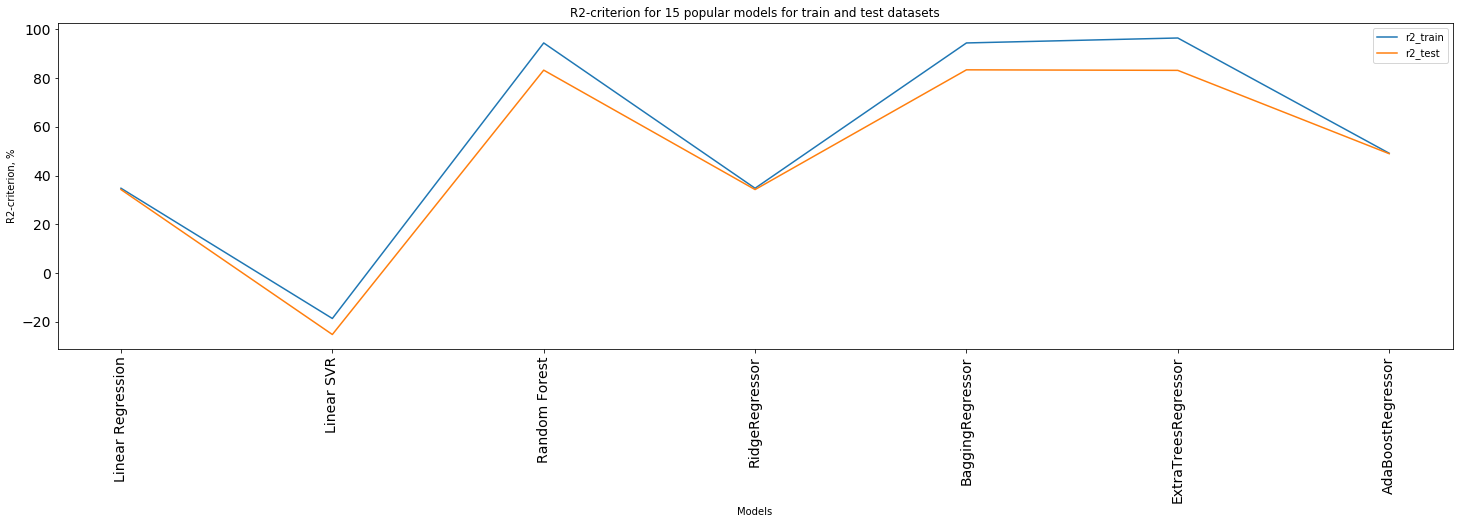

In [95]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['r2_train'], label = 'r2_train')
plt.plot(xx, models['r2_test'], label = 'r2_test')
plt.legend()
plt.title('R2-criterion for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('R2-criterion, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

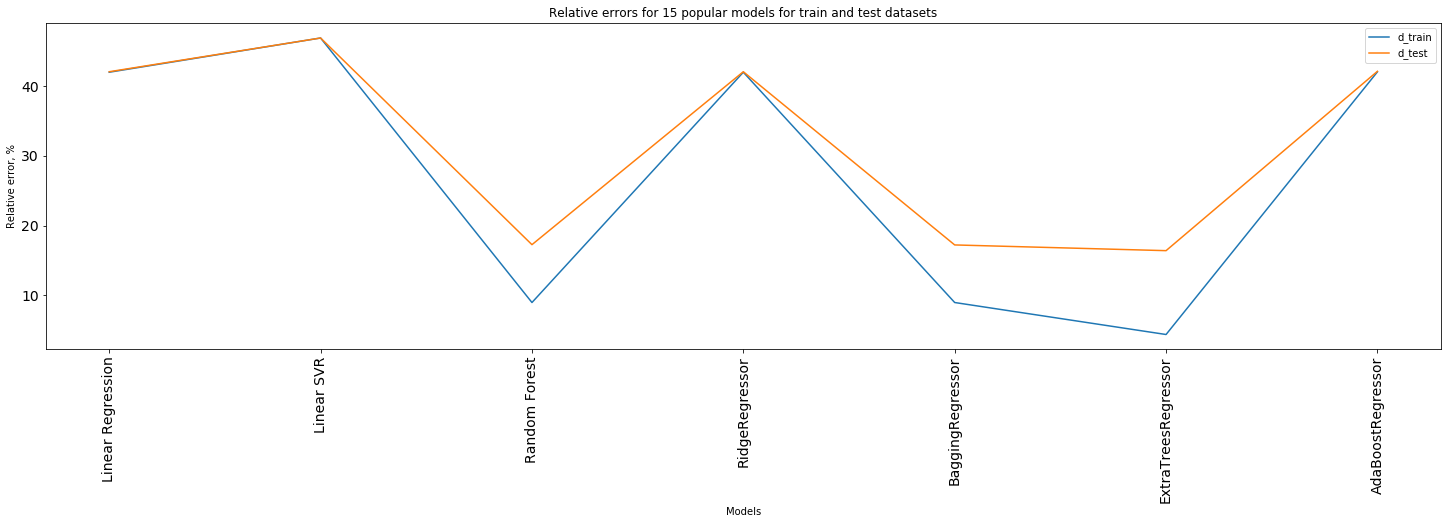

In [97]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['d_train'], label = 'd_train')
plt.plot(xx, models['d_test'], label = 'd_test')
plt.legend()
plt.title('Relative errors for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Relative error, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

In [100]:
import seaborn as sns

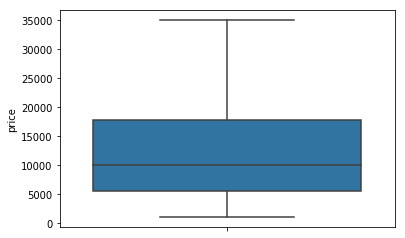

In [109]:
sns.boxplot(y = train0[train0.price<35000].price)

In [114]:
sample = train0[train0.price<35000]

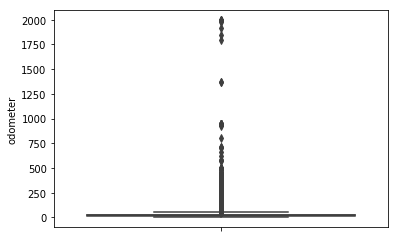

In [128]:
sns.boxplot(y = train.odometer)